# MNIST Buildup

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Compose, Resize, AutoAugment, RandomInvert, RandomGrayscale, RandomHorizontalFlip, RandomVerticalFlip, ConvertImageDtype
import time
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor
import warnings
warnings.filterwarnings("ignore")
import torchmetrics

## For a deep understanding of machine learning.

The goal is to make progressingly complicated models of MNIST to learn what *actaully* improved with new model complexity.  I want to take a fixed parameter size (200k, the MNIST length) and find out from my own experimentation what is a good idea versus what is not.  I realize the correct way to understand things is to go beyond MNIST, but let's start here.

#### MNIST Dataset

In [2]:
# Import Datasets
class FashionMNIST:
    def __init__(self, batch_size=64) -> None:
        # Get datasets
        #transforms = Compose([ToTensor(), RandomInvert()])
        transforms = Compose([ToTensor(),ConvertImageDtype(dtype=torch.uint8), AutoAugment(), ConvertImageDtype(dtype=torch.float32)])
        transforms = Compose([ToTensor(),Resize((64,64))])
        self.train = datasets.FashionMNIST(root='data', train=True, transform=transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 938, 157)

In [3]:
# Import Datasets
class CIFAR10:
    def __init__(self, batch_size=64) -> None:
        # Get datasets
        transforms1 = Compose([ToTensor(),ConvertImageDtype(dtype=torch.uint8), AutoAugment(), ConvertImageDtype(dtype=torch.float32)])
        transforms2 = Compose([ToTensor(),Resize((64,64))])

        self.train = datasets.CIFAR10(root='data', train=True, transform=transforms1)
        self.val = datasets.CIFAR10(root='data', train=False, transform=ToTensor())

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)

data = CIFAR10()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(50000, 10000, 782, 157)

In [4]:
x, y = next(iter(data.train_dl))

x[0].max()

tensor(0.9216)

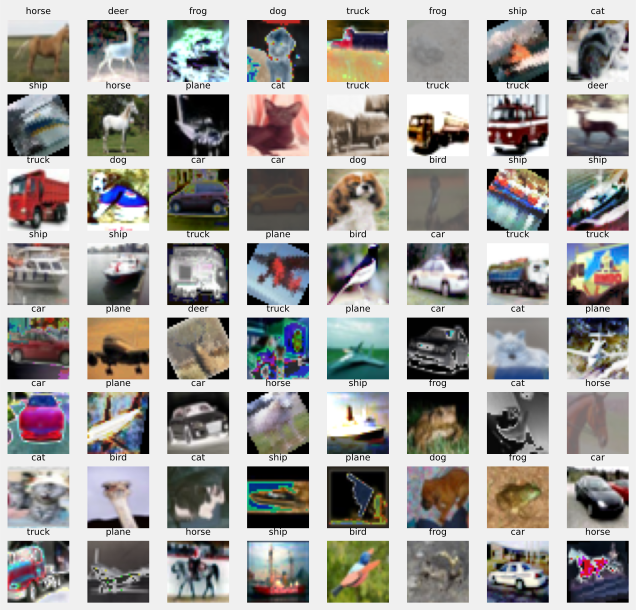

In [10]:
# Check out dataset

plt.figure(figsize=(10,10))#figsize=(1,1))
x, y = next(iter(data.train_dl))

#x = x[torch.argsort(y)]
#y = y[torch.argsort(y)]

labels = ['plane', 'car', 'bird', 'cat', 'deer','dog','frog','horse','ship','truck']

for i in range(64):

    plt.subplot(8, 8, i+1)
    img = x.permute(0,2,3,1)
    plt.imshow(img[i])
    plt.title(labels[y[i].item()], fontsize =9)
    plt.axis('off')

In [5]:
class MyModule(nn.Module):
    def __init__(self, lr=0.0001):
        super().__init__()
        self.learning_rate = lr

    def forward(self, x):
        out = self.model(x)
        return out

    def init_cnn(self, module):  #@save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            #nn.init.xavier_uniform_(module.weight)
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity = 'relu')

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

    def loss_fn(self, logits, y):
        loss = nn.functional.cross_entropy(logits, y)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

### One layer linear model

MNIST: batchsize = 512, lr = 2e-4
* MNIST at epoch  1: "Epoch   1 has train loss 1.5955, val loss 1.6547, and accuracy 0.5020"
* MNIST at epoch 10: "Epoch  10 has train loss 0.7915, val loss 0.7172, and accuracy 0.7598"
* MNIST at epoch 20: "Epoch  20 has train loss 0.6104, val loss 0.5904, and accuracy 0.8086"
* MNIST at epoch 100: train loss = 0.36, val loss = 0.48, val accuracy = 0.83

CIFAR10: batchsize = 512, lr = 2e-5, cpu runtime: 3m 39s
* CIFAR10 at epoch 1: "Epoch   1 has train loss 2.2772, val loss 2.2745, and accuracy 0.1504"
* CIFAR10 at epoch 10: "Epoch  10 has train loss 2.0047, val loss 1.9894, and accuracy 0.3125"
* CIFAR10 at epoch 20: "Epoch  20 has train loss 1.8781, val loss 1.8714, and accuracy 0.3633"
* CIFAR10 at 100: train loss = 1.80, val loss = 1.78, val accuracy = 0.38


In [ ]:
class SingleLinear(MyModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(), nn.LazyLinear(10))

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits


Model as 30730 parameters
Epoch   0 has train loss 2.3538, val loss 2.3538, and accuracy 0.0820
Epoch   1 has train loss 2.2917, val loss 2.3014, and accuracy 0.1270
Epoch   2 has train loss 2.2608, val loss 2.2332, and accuracy 0.1680
Epoch   3 has train loss 2.2386, val loss 2.2103, and accuracy 0.2031
Epoch   4 has train loss 2.1736, val loss 2.1472, and accuracy 0.2285
Epoch   5 has train loss 2.1365, val loss 2.1666, and accuracy 0.2090
Epoch   6 has train loss 2.1168, val loss 2.0944, and accuracy 0.2500
Epoch   7 has train loss 2.0976, val loss 2.0919, and accuracy 0.2324
Epoch   8 has train loss 2.0401, val loss 2.1013, and accuracy 0.2480
Epoch   9 has train loss 2.0490, val loss 2.0655, and accuracy 0.2734
Epoch  10 has train loss 2.0835, val loss 2.0548, and accuracy 0.2715
Epoch  11 has train loss 2.0130, val loss 2.0412, and accuracy 0.2734
Epoch  12 has train loss 1.9671, val loss 2.0269, and accuracy 0.3184
Epoch  13 has train loss 2.0232, val loss 1.9578, and accuracy 0

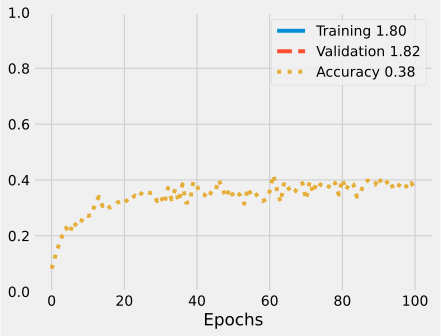

In [ ]:
device = "cpu"
max_epochs = 100

# Data
data = CIFAR10(batch_size=512)
#data = FashionMNIST(batch_size=512)

# Model
model = SingleLinear().to(device)

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to(device), y.to(device)
val_logits = model.init(x)

# Number of parameters
print(f'Model as {sum([p.numel() for p in model.parameters()])} parameters')


# Initial loss
val_loss = model.loss_fn(val_logits, y).item()
val_acc = model.accuracy(val_logits, y).item()
print(f'Epoch {0:>3d} has train loss {val_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')


N = len(data.train_dl)
lr = torch.logspace(-6, -3, N)
losses = torch.zeros(N)
#model.optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-5)
model.optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-5)

ptloss = torch.zeros(max_epochs+1); ptloss[0] = val_loss
pvloss = torch.zeros(max_epochs+1); pvloss[0] = val_loss
pvacc = torch.zeros(max_epochs+1); pvacc[0] = val_acc
for epoch in range(1, max_epochs+1):
    model.train()
    for step, batch in enumerate(data.train_dl):

        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        losses[step] = train_loss.item()

        # Update
        #model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        #if step % 50 == 0:
        #    print(f'step {step} has loss {train_loss.item()}')

    # Evaluate for epoch
    model.eval()
    x, y = next(iter(data.val_dl))
    x, y = x.to(device), y.to(device)
    val_logits = model(x)
    val_loss = model.loss_fn(val_logits, y).item()
    val_acc = model.accuracy(val_logits, y).item()
    ptloss[epoch] = train_loss.item()
    pvloss[epoch] = val_loss
    pvacc[epoch] = val_acc
    print(f'Epoch {epoch:>3d} has train loss {train_loss.item():.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')

    #break

# Plot
plt.figure()
epochs = torch.arange(max_epochs + 1).detach()
plt.plot(epochs, ptloss, 'C0-', label=f'Training {ptloss[-4:].mean():.2f}')
plt.plot(epochs, pvloss, 'C1--', label=f'Validation {pvloss[-4:].mean():.2f}')
plt.plot(epochs, pvacc, 'C2:', label=f'Accuracy {pvacc[-4:].mean():.2f}')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.legend();


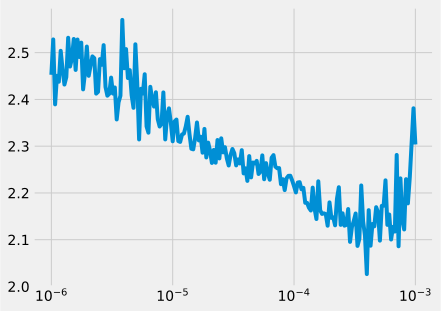

In [ ]:
plt.semilogx(lr, losses)

### Two layer linear model

MNIST: batchsize = 512, lr = 2e-4, cpu runtime: 2m 55s
* MNIST at epoch  1: "Epoch   1 has train loss 0.7872, val loss 0.7667, and accuracy 0.7480"
* MNIST at epoch 10: "Epoch  10 has train loss 0.3400, val loss 0.4438, and accuracy 0.8340"
* MNIST at epoch 20: "Epoch  20 has train loss 0.2750, val loss 0.4028, and accuracy 0.8652"
* MNIST at epoch 100: train loss = 0.22, val loss = 0.33, val accuracy = 0.88

CIFAR10: batchsize = 512, lr = 2e-5, cpu runtime: 3m 58s
* CIFAR10 at epoch 1: "Epoch   1 has train loss 2.1602, val loss 2.1781, and accuracy 0.2207"
* CIFAR10 at epoch 10: "Epoch  10 has train loss 1.9659, val loss 1.9152, and accuracy 0.3477"
* CIFAR10 at epoch 20: "Epoch  20 has train loss 1.7603, val loss 1.7274, and accuracy 0.4180"
* CIFAR10 at 100: train loss = 1.56, val loss = 1.60, val accuracy = 0.44

In [ ]:
class DoubleLinear(MyModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(), nn.LazyLinear(128), nn.ReLU(), nn.LazyLinear(10))

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits

Model as 394634 parameters
Epoch   0 has train loss 2.3121, val loss 2.3121, and accuracy 0.0840
Epoch   1 has train loss 2.3029, val loss 2.2906, and accuracy 0.1240
Epoch   2 has train loss 2.2444, val loss 2.2495, and accuracy 0.1504
Epoch   3 has train loss 2.2116, val loss 2.1924, and accuracy 0.2100
Epoch   4 has train loss 2.1600, val loss 2.1574, and accuracy 0.2080
Epoch   5 has train loss 2.1530, val loss 2.1304, and accuracy 0.2412
Epoch   6 has train loss 2.0974, val loss 2.1126, and accuracy 0.2412
Epoch   7 has train loss 2.0856, val loss 2.0672, and accuracy 0.2646
Epoch   8 has train loss 2.0750, val loss 2.0583, and accuracy 0.2646
Epoch   9 has train loss 2.0586, val loss 2.0617, and accuracy 0.2666
Epoch  10 has train loss 1.9998, val loss 2.0169, and accuracy 0.2744
Epoch  11 has train loss 1.9932, val loss 2.0008, and accuracy 0.2842
Epoch  12 has train loss 1.9875, val loss 1.9944, and accuracy 0.3076
Epoch  13 has train loss 1.9752, val loss 1.9538, and accuracy 

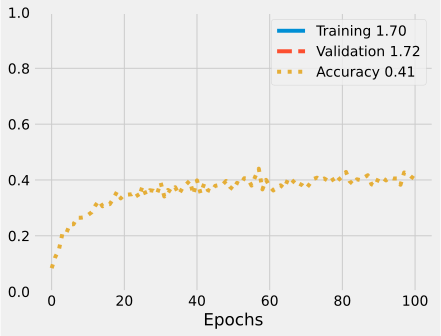

In [ ]:
device = "cpu"
max_epochs = 100

# Data
#data = FashionMNIST(batch_size=512)
data = CIFAR10(batch_size=1024)


# Model
model = DoubleLinear().to(device)

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to(device), y.to(device)
val_logits = model.init(x)

# Number of parameters
print(f'Model as {sum([p.numel() for p in model.parameters()])} parameters')


# Initial loss
val_loss = model.loss_fn(val_logits, y).item()
val_acc = model.accuracy(val_logits, y).item()
print(f'Epoch {0:>3d} has train loss {val_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')


N = len(data.train_dl)
lr = torch.logspace(-6, -1, N)
losses = torch.zeros(N)
model.optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-5)
ptloss = torch.zeros(max_epochs+1); ptloss[0] = val_loss
pvloss = torch.zeros(max_epochs+1); pvloss[0] = val_loss
pvacc = torch.zeros(max_epochs+1); pvacc[0] = val_acc
for epoch in range(1, max_epochs+1):
    model.train()
    for step, batch in enumerate(data.train_dl):

        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        losses[step] = train_loss.item()

        # Update
        # model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        # if step % 20 == 0:
        #    print(f'step {step} has loss {train_loss.item()}')

    # Evaluate for epoch
    model.eval()
    x, y = next(iter(data.val_dl))
    x, y = x.to(device), y.to(device)
    val_logits = model(x)
    val_loss = model.loss_fn(val_logits, y).item()
    val_acc = model.accuracy(val_logits, y).item()
    ptloss[epoch] = train_loss.item()
    pvloss[epoch] = val_loss
    pvacc[epoch] = val_acc
    print(f'Epoch {epoch:>3d} has train loss {train_loss.item():.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')

    # break

# Plot
plt.figure()
epochs = torch.arange(max_epochs + 1).detach()
plt.plot(epochs, ptloss, 'C0-', label=f'Training {ptloss[-5:].mean():.2f}')
plt.plot(epochs, pvloss, 'C1--', label=f'Validation {pvloss[-5:].mean():.2f}')
plt.plot(epochs, pvacc, 'C2:', label=f'Accuracy {pvacc[-5:].mean():.2f}')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.legend();

## 3 layer model (100k MNIST)

A third layer with ~100k paremeters

MNIST: batchsize = 512, lr = 5e-5, cpu runtime: 2m 55s
* MNIST at epoch  1: "Epoch   1 has train loss 1.4834, val loss 1.3517, and accuracy 0.6250"
* MNIST at epoch 10: "Epoch  10 has train loss 0.3660, val loss 0.5407, and accuracy 0.8203"
* MNIST at epoch 20: "Epoch  20 has train loss 0.4677, val loss 0.4194, and accuracy 0.8633"
* MNIST at epoch 100: train loss = 0.21, val loss = 0.34, val accuracy = 0.88

CIFAR10: batchsize = 512, lr = 2e-5, cpu runtime: 3m 58s
* CIFAR10 at epoch 1: "Epoch   1 has train loss 2.0729, val loss 2.0993, and accuracy 0.2773"
* CIFAR10 at epoch 10: "Epoch  10 has train loss 1.7130, val loss 1.7197, and accuracy 0.3965"
* CIFAR10 at epoch 20: "Epoch  20 has train loss 1.6775, val loss 1.6635, and accuracy 0.4180"
* CIFAR10 at 100: train loss = 1.53, val loss = 1.53, val accuracy = 0.47

In [ ]:
class TripleLinear100(MyModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(),
                                   nn.LazyLinear(128), nn.ReLU(), 
                                   nn.LazyLinear(64), nn.ReLU(),
                                   nn.LazyLinear(10))

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits


# Data
data = FashionMNIST(batch_size=512)
#data = CIFAR10(batch_size=1024)

# Model
model = TripleLinear100()

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
val_logits = model.init(x)

# Number of parameters
print(f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')


Model "TripleLinear100" has 109386 parameters


In [54]:
device = "cpu"
max_epochs = 100

# Data
data = FashionMNIST(batch_size=512)
#data = CIFAR10(batch_size=512)


# Model
model = TripleLinear100().to(device)

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to(device), y.to(device)
val_logits = model.init(x)

# Number of parameters
print(f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')


# Initial loss
val_loss = model.loss_fn(val_logits, y).item()
val_acc = model.accuracy(val_logits, y).item()
print(f'Epoch {0:>3d} has train loss {val_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')


N = len(data.train_dl)
lr = torch.logspace(-6, -1, N)
losses = torch.zeros(N)
LR = 2.0e-5
model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
ptloss = torch.zeros(max_epochs+1); ptloss[0] = val_loss
pvloss = torch.zeros(max_epochs+1); pvloss[0] = val_loss
pvacc = torch.zeros(max_epochs+1); pvacc[0] = val_acc
for epoch in range(1, max_epochs+1):
    model.train()
    if epoch % 25 == 0:
        LR = LR/2.0
        print (f'Changing LR to {LR}')
        model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    for step, batch in enumerate(data.train_dl):

        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        losses[step] = train_loss.item()

        # model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        # if step % 20 == 0:
        #    print(f'step {step} has loss {train_loss.item()}')

    # Evaluate for epoch
    model.eval()
    x, y = next(iter(data.val_dl))
    x, y = x.to(device), y.to(device)
    val_logits = model(x)
    val_loss = model.loss_fn(val_logits, y).item()
    val_acc = model.accuracy(val_logits, y).item()
    ptloss[epoch] = train_loss.item()
    pvloss[epoch] = val_loss
    pvacc[epoch] = val_acc
    print(f'Epoch {epoch:>3d} has train loss {train_loss.item():.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')

    # break

# Plot
plt.figure()
epochs = torch.arange(max_epochs + 1).detach()
plt.plot(epochs, ptloss, 'C0-', label=f'Training {ptloss[-5:].mean():.2f}')
plt.plot(epochs, pvloss, 'C1--', label=f'Validation {pvloss[-5:].mean():.2f}')
plt.plot(epochs, pvacc, 'C2:', label=f'Accuracy {pvacc[-5:].mean():.2f}')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.legend();

NameError: name 'TripleLinear100' is not defined

### One layer linear model

MNIST: batchsize = 512, lr = 2e-4
* MNIST at epoch  1: "Epoch   1 has train loss 1.5955, val loss 1.6547, and accuracy 0.5020"
* MNIST at epoch 10: "Epoch  10 has train loss 0.7915, val loss 0.7172, and accuracy 0.7598"
* MNIST at epoch 20: "Epoch  20 has train loss 0.6104, val loss 0.5904, and accuracy 0.8086"
* MNIST at epoch 100: train loss = 0.34, val loss = 0.44, val accuracy = 0.84

CIFAR10: batchsize = 512, lr = 2e-5, cpu runtime: 3m 39s
* CIFAR10 at epoch 1: "Epoch   1 has train loss 2.2772, val loss 2.2745, and accuracy 0.1504"
* CIFAR10 at epoch 10: "Epoch  10 has train loss 2.0047, val loss 1.9894, and accuracy 0.3125"
* CIFAR10 at epoch 20: "Epoch  20 has train loss 1.8781, val loss 1.8714, and accuracy 0.3633"
* CIFAR10 at 100: train loss = 1.80, val loss = 1.78, val accuracy = 0.38

## 2 layer model (100k MNIST)


MNIST: batchsize = 512, lr = 2e-4, cpu runtime: 2m 55s
* MNIST at epoch  1: "Epoch   1 has train loss 0.7872, val loss 0.7667, and accuracy 0.7480"
* MNIST at epoch 10: "Epoch  10 has train loss 0.3400, val loss 0.4438, and accuracy 0.8340"
* MNIST at epoch 20: "Epoch  20 has train loss 0.2750, val loss 0.4028, and accuracy 0.8652"
* MNIST at epoch 100: train loss = 0.18, val loss = 0.32, val accuracy = 0.89

CIFAR10: batchsize = 512, lr = 2e-5, cpu runtime: 3m 58s
* CIFAR10 at epoch 1: "Epoch   1 has train loss 2.1602, val loss 2.1781, and accuracy 0.2207"
* CIFAR10 at epoch 10: "Epoch  10 has train loss 1.9659, val loss 1.9152, and accuracy 0.3477"
* CIFAR10 at epoch 20: "Epoch  20 has train loss 1.7603, val loss 1.7274, and accuracy 0.4180"
* CIFAR10 at 100: train loss = 1.56, val loss = 1.60, val accuracy = 0.44

## 3 layer model (100k MNIST)

A third layer with ~100k paremeters

MNIST: batchsize = 512, lr = 5e-5, cpu runtime: 2m 55s
* MNIST at epoch  1: "Epoch   1 has train loss 1.4834, val loss 1.3517, and accuracy 0.6250"
* MNIST at epoch 10: "Epoch  10 has train loss 0.3660, val loss 0.5407, and accuracy 0.8203"
* MNIST at epoch 20: "Epoch  20 has train loss 0.4677, val loss 0.4194, and accuracy 0.8633"
* MNIST at epoch 100: train loss = 0.12, val loss = 0.35, val accuracy = 0.89

CIFAR10: batchsize = 512, lr = 2e-5, cpu runtime: 3m 58s
* CIFAR10 at epoch 1: "Epoch   1 has train loss 2.0729, val loss 2.0993, and accuracy 0.2773"
* CIFAR10 at epoch 10: "Epoch  10 has train loss 1.7130, val loss 1.7197, and accuracy 0.3965"
* CIFAR10 at epoch 20: "Epoch  20 has train loss 1.6775, val loss 1.6635, and accuracy 0.4180"
* CIFAR10 at 100: train loss = 1.39, val loss = 1.51, val accuracy = 0.51

## 3 layer model + dropout (100k MNIST)

A third layer with ~100k paremeters + dropout

MNIST: batchsize = 256, lr = 5e-5, cpu runtime: 2m 55s
* MNIST at epoch  1: "Epoch   1 has train loss 1.4834, val loss 1.3517, and accuracy 0.6250"
* MNIST at epoch 10: "Epoch  10 has train loss 0.3660, val loss 0.5407, and accuracy 0.8203"
* MNIST at epoch 20: "Epoch  20 has train loss 0.4677, val loss 0.4194, and accuracy 0.8633"
* MNIST at epoch 100: train loss = 0.26, val loss = 0.26, val accuracy = 0.90

CIFAR10: batchsize = 256, lr = 8e-5, cpu runtime: 4m 58s
* CIFAR10 at epoch 1: "Epoch   1 has train loss 2.2924, val loss 2.1868, and accuracy 0.2188"
* CIFAR10 at epoch 10: "Epoch  10 has train loss 1.9622, val loss 1.7605, and accuracy 0.4336"
* CIFAR10 at epoch 20: "Epoch  20 has train loss 1.6984, val loss 1.7916, and accuracy 0.4336"
* CIFAR10 at 100: train loss = 1.23, val loss = 1.23, val accuracy = 0.57

In [ ]:
class TripleLinear100(MyModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(),
                                   nn.LazyLinear(128), nn.ReLU(), 
                                   nn.LazyLinear(64), nn.ReLU(),
                                   nn.LazyLinear(10))

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits


# Data
data = FashionMNIST(batch_size=512)
#data = CIFAR10(batch_size=1024)

# Model
model = TripleLinear100()

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
val_logits = model.init(x)

# Number of parameters
print(f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')

Model "TripleLinear100" has 109386 parameters


In [88]:
class TripleLinear100d(MyModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(),
                                   nn.LazyLinear(), nn.ReLU(), nn.Dropout(0.5),
                                   nn.LazyLinear(128), nn.ReLU(), nn.Dropout(0.5),
                                   nn.LazyLinear(64), nn.ReLU(), nn.Dropout(0.5),
                                   nn.LazyLinear(10))

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits


# Data
data = FashionMNIST(batch_size=512)
# data = CIFAR10(batch_size=1024)

# Model
model = TripleLinear100()

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
val_logits = model.init(x)

# Number of parameters
print(
    f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')


NameError: name 'TripleLinear100' is not defined

In [6]:
class Residule(nn.Module):
    def __init__(self, out_channels, stride = 1, do_conv=True) -> None:
        super().__init__()
        self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, padding=1)
        
        self.bn1 = nn.LazyBatchNorm2d(device="mps")
        self.bn2 = nn.LazyBatchNorm2d(device="mps")
        self.do_conv = do_conv
        if self.do_conv:
            self.conv3 = nn.LazyConv2d(out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.do_conv:
            x = self.conv3(x)
        out += x
        return torch.relu(out)


class ResNet18(MyModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( self.stem(48), 
                                    Residule(48, do_conv=False),
                                    Residule(48, do_conv=False),
                                    Residule(96, stride=2),
                                    Residule(96, do_conv=False),# ,
                                    Residule(192, stride=2),
                                    Residule(192, do_conv=False),nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                                    nn.Flatten(),
                                    nn.LazyLinear(10))
    
    def stem(self,out_channels):
        return nn.Sequential(nn.LazyConv2d( out_channels, kernel_size=7, stride=2, padding=3), 
                             nn.LazyBatchNorm2d(device="mps"), nn.ReLU(), 
                             nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits


# Data
#data = FashionMNIST(batch_size=512)
data = CIFAR10(batch_size=1024)

# Model
model = ResNet18().to("mps")

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to("mps"), y.to("mps")
val_logits = model.init(x)

print (x.shape)
print (val_logits.shape)

# Number of parameters
print(
    f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')

#print (model)

torch.Size([1024, 3, 32, 32])
torch.Size([1024, 10])
Model "ResNet18" has 1570954 parameters


In [112]:
3*32*32, 48*8*8, 96*4, 192*2

(3072, 3072, 384, 384)

In [9]:
device = "mps"
max_epochs = 100

# Data
#data = FashionMNIST(batch_size=512)
data = CIFAR10(batch_size=1024)


# Model
#model = SingleLinear().to(device)
#model = DoubleLinear().to(device)""
#model = TripleLinear100().to(device)
#model = TripleLinear100().to(device)
model = ResNet18().to(device)


# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to(device), y.to(device)
val_logits = model.init(x)

# Number of parameters
print(f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')


# Initial loss
val_loss = model.loss_fn(val_logits, y).item()
val_acc = model.accuracy(val_logits, y).item()
print(f'Epoch {0:>3d} has train loss {val_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')


N = len(data.train_dl)
lr = torch.logspace(-6, -3, N)
losses = torch.zeros(N)
#LR = 4.0e-3
LR = 1e-4

model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
ptloss = torch.zeros(max_epochs+1); ptloss[0] = val_loss
pvloss = torch.zeros(max_epochs+1); pvloss[0] = val_loss
pvacc = torch.zeros(max_epochs+1); pvacc[0] = val_acc
for epoch in range(1, max_epochs+1):
    model.train()
    if epoch % 400 == 0:
        LR = LR/2.0
        print (f'Changing LR to {LR}')
        model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    for step, batch in enumerate(data.train_dl):

        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        losses[step] = train_loss.item()

        #model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        #if step % 20 == 0:
        #    print(f'step {step} has loss {train_loss.item()}')
    #break
    # Evaluate for epoch
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            vx, vy = next(iter(data.val_dl))
            vx, vy = vx.to(device), vy.to(device)
            val_logits = model(vx)
            val_loss = model.loss_fn(val_logits, vy).item()
            val_acc = model.accuracy(val_logits, vy).item()
            ptloss[epoch] = train_loss.item()
            pvloss[epoch] = val_loss
            pvacc[epoch] = val_acc
        print(f'Epoch {epoch:>3d} has train loss {train_loss.item():.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')

    #break



# Get final training loss:
model.eval()
ftloss = []
for batch in data.train_dl:
    # Get Minibatch
    x, y = batch
    x, y = x.to(device), y.to(device)

    # Get logits
    train_logits = model(x)

    # Get loss
    train_loss = model.loss_fn(train_logits, y)
    ftloss.append(train_loss)

fvloss = []
fvacc = []
for batch in data.val_dl:
    # Get Minibatch
    x, y = batch
    x, y = x.to(device), y.to(device)

    # Get logits
    val_logits = model(x)

    # Get loss
    val_loss = model.loss_fn(val_logits, y)
    val_acc = model.accuracy(val_logits, y).item()
    fvloss.append(val_loss)
    fvacc.append(val_acc)


ftloss = torch.tensor(ftloss).mean().item()
fvloss = torch.tensor(fvloss).mean().item()
fvacc = torch.tensor(fvacc).mean().item()


# Plot
plt.figure()
epochs = torch.arange(max_epochs + 1).detach()
plt.plot(epochs, ptloss, 'C0-', label=f'Training {ftloss:.2f}')
plt.plot(epochs, pvloss, 'C1--', label=f'Validation {fvloss:.2f}')
plt.plot(epochs, pvacc, 'C2:', label=f'Accuracy {fvacc:.2f}')
plt.ylim(0,2)
plt.xlabel('Epochs')
plt.legend();




Model "ResNet18" has 1570954 parameters
Epoch   0 has train loss 2.3592, val loss 2.3592, and accuracy 0.1133
Epoch  10 has train loss 1.5297, val loss 1.2728, and accuracy 0.5537
Epoch  20 has train loss 1.2503, val loss 1.0919, and accuracy 0.6064
Epoch  30 has train loss 1.1018, val loss 1.1425, and accuracy 0.5977
Epoch  40 has train loss 0.9497, val loss 0.9867, and accuracy 0.6641
Epoch  50 has train loss 0.8958, val loss 1.0215, and accuracy 0.6445
Epoch  60 has train loss 0.8207, val loss 1.0278, and accuracy 0.6484
Epoch  70 has train loss 0.7465, val loss 1.0657, and accuracy 0.6475
Epoch  80 has train loss 0.6827, val loss 1.1290, and accuracy 0.6514


KeyboardInterrupt: 

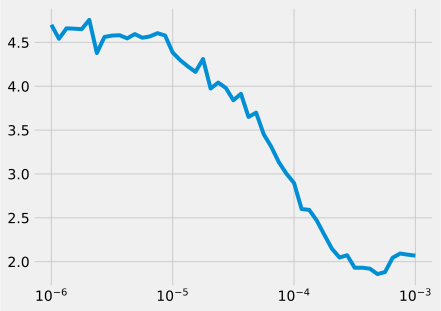

In [124]:
plt.semilogx(lr, losses)
#plt.ylim(2.2,2.5)

In [8]:
del(model)
del(x)
del(y)
del(vx)
del(vy)

In [ ]:
#data = CIFAR10(batch_size=256)
#data = FashionMNIST(batch_size=256)



# Model
#model = SingleLinear().to(device)
#model = DoubleLinear().to(device)
#model = TripleLinear100().to(device)
model = nn.Sequential(nn.LazyConv2d(48, kernel_size=7, stride=2, padding=3), nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)).to("mps")

# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to(device), y.to(device)
val_logits = model(x)
print(f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')
print (x.shape)
print (val_logits.shape)

Model "Sequential" has 7200 parameters
torch.Size([2048, 3, 32, 32])
torch.Size([2048, 48, 8, 8])


3 layer 100k + dropout + skip

In [ ]:
3*32*32, 48*8*8, 96*4*4, 96*2

(3072, 3072, 1536, 192)